# WOfS Validation Data Analysis - Water Body Type Classification  <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2),
[ga_ls8c_wofs_2_annual_summary ](https://explorer.digitalearth.africa/ga_ls8c_wofs_2_annual_summary)

## Background
The [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) is a derived product from Landsat 8 satellite observations as part of provisional Landsat 8 Collection 2 surface reflectance and shows surface water detected in Africa.
Individual water classified images are called Water Observation Feature Layers (WOFLs), and are created in a 1-to-1 relationship with the input satellite data. 
Hence there is one WOFL for each satellite dataset processed for the occurrence of water.

The data in a WOFL is stored as a bit field. This is a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular attribute (water, cloud, cloud shadow etc). In this way, the single decimal value associated to each pixel can provide information on a variety of features of that pixel. 
For more information on the structure of WOFLs and how to interact with them, see [Water Observations from Space](../Datasets/Water_Observations_from_Space.ipynb) and [Applying WOfS bitmasking](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb) notebooks.

## Description
This notebook explains how you can perform validation analysis for WOFS derived product using collected ground truth dataset and window-based sampling. 

The notebook demonstrates how to:

1. Load validation points for each partner institutions following cleaning stage as an ESRI shapefile
2. Query WOFL data for validation points and capture available WOfS observation available
3. Extract statistics for each WOfS observation in each validation point using a 3 by 3 window and multiprocessing functionality 
4. Extract a LUT for each point that contains both validation info and WOfS result for each month 
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

After finishing the analysis, you can modify some values in the "Analysis parameters" cell and re-run the analysis to load WOFLs for a different location or time period.

### Load packages
Import Python packages that are used for the analysis.

In [84]:
%matplotlib inline

import time 
import datacube
from datacube.utils import masking, geometry 
import sys
import os
import dask 
import rasterio, rasterio.features
import xarray
import glob
import numpy as np
import pandas as pd
import seaborn as sn
import geopandas as gpd
import subprocess as sp
import matplotlib.pyplot as plt
import scipy, scipy.ndimage
import warnings
warnings.filterwarnings("ignore") #this will suppress the warnings for multiple UTM zones in your AOI 

sys.path.append("../Scripts")
from rasterio.mask import mask
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
from sklearn import metrics 
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import plot_confusion_matrix, f1_score, mean_squared_error
from sklearn.metrics import jaccard_score
from deafrica_plotting import map_shapefile,display_map, rgb
from deafrica_spatialtools import xr_rasterize
from deafrica_datahandling import wofs_fuser, mostcommon_crs,load_ard,deepcopy
from deafrica_dask import create_local_dask_cluster

#for parallelisation 
from multiprocessing import Pool, Manager
import multiprocessing as mp
from tqdm import tqdm

### Analysis parameters

To analyse validation points collected by each partner institution, we need to obtain WOfS surface water observation data that corresponds with the labelled input data locations. 

### Loading Dataset

1. Load validation points for each partner institutions as a list of observations each has a location and month
    * Load the cleaned validation file as ESRI `shapefile`
    * Inspect the shapefile

We will focus on the actual and prediction values of the table to understand the frequency of clear water observations in CEO and WOfS as well as distribution graph.

In [113]:
#Read the ground truth data following analysis step 
CEO = '../Supplementary_data/Validation/Refined/NewAnalysis/Continent/WOfS_processed/Intitutions/Point_Based/AEZs/ValidPoints/ValidationPoints_Western.csv'
input_data = pd.read_csv(CEO,delimiter=",")

In [114]:
input_data.columns

Index(['Unnamed: 0', 'PLOT_ID', 'LON', 'LAT', 'CLASS', 'MONTH', 'ACTUAL',
       'CLASS_WET', 'CLEAR_OBS', 'PREDICTION'],
      dtype='object')

In [115]:
input_data=input_data.drop(['Unnamed: 0'], axis=1)

In [116]:
input_data

,PLOT_ID,LON,LAT,CLASS,MONTH,ACTUAL,CLASS_WET,CLEAR_OBS,PREDICTION
0,137483266.0,5.270490,12.587901,Open water - freshwater,1,1,0.0,1.0,0
1,137483266.0,5.270490,12.587901,Open water - freshwater,2,1,0.0,1.0,0
2,137483266.0,5.270490,12.587901,Open water - freshwater,3,1,1.0,3.0,1
3,137483266.0,5.270490,12.587901,Open water - freshwater,4,1,1.0,1.0,1
4,137483266.0,5.270490,12.587901,Open water - freshwater,5,1,1.0,3.0,1
...,...,...,...,...,...,...,...,...,...
828,137712352.0,6.026038,4.435646,Open water - marine,12,1,1.0,1.0,1
829,137712353.0,5.840416,4.426212,Open water - marine,1,1,1.0,1.0,1
830,137712354.0,6.631720,4.347916,Open water - marine,1,1,1.0,1.0,1
831,137712354.0,6.631720,4.347916,Open water - marine,3,1,1.0,1.0,1


In [117]:
input_data['Actual_Sum'] = input_data['ACTUAL'].groupby(input_data['PLOT_ID']).transform('sum')

In [118]:
input_data['WOfS_Sum'] = input_data['PREDICTION'].groupby(input_data['PLOT_ID']).transform('sum')

In [119]:
#input_data.loc[input_data['PLOT_ID'] == 137755802]

In [120]:
input_data['Actual_count'] = input_data.groupby('PLOT_ID')['ACTUAL'].transform('count')
input_data['WOfS_count'] = input_data.groupby('PLOT_ID')['PREDICTION'].transform('count')

In [121]:
input_data['WOfS_Wet_Sum'] = input_data['CLASS_WET'].groupby(input_data['PLOT_ID']).transform('sum')
input_data['WOfS_Clear_Sum'] = input_data['CLEAR_OBS'].groupby(input_data['PLOT_ID']).transform('sum')

### Classification Method

Having access to the actual labels for each validation points extracted from CEO tool and predicted values from WOfS query, the frequency of water observation for each validation point was extracted by using the following two formulas:

CEO_FREQUENCY = ∑ (ACTUAL) / count (ACTUAL)

WOfS_FREQUENCY = ∑ (PREDICTION) / count (PREDICTION)

Please take into the consideration that WOfs query for the dataset validated by RCMRD is based on entire calendar month (i.e. Eastern and Indian Ocean AEZ) while the WOfS query for dataset validated by other three institutions are based on (+/- 5 days) in each calendar month. 

We also tested an alternative approach for comparing with the above method. In this approach the CEO_frequecy is being evaluated against the WOfS frequency that is extracted from the following formula: 

WOfS_FREQ = ∑ (CLASS_WET) / ∑ (CLEAR_OBS)

Using thresholding method, the frequency values for both CEO and WOfS will be categorised in three distict classes i.e. dry, ephemeral and permanent water features for further accuracy assessment. 

In [122]:
input_data['CEO_FREQUENCY'] = input_data['Actual_Sum']/input_data['Actual_count']
input_data['WOfS_FREQUENCY'] = input_data['WOfS_Sum']/input_data['WOfS_count']

In [123]:
#Define water body classes for WOfS based on thresholding 
input_data.loc[input_data['WOfS_Sum'] == 0.0, 'WOfS_TYPE'] = 'Permanent'
input_data.loc[(input_data['WOfS_Sum'] != 0.0) & (input_data['WOfS_FREQUENCY'] == 1.0), 'WOfS_TYPE'] = 'Permanent'  
input_data.loc[(input_data['WOfS_Sum'] != 0.0) & (input_data['WOfS_FREQUENCY'] < 1.0) & (input_data['WOfS_FREQUENCY'] != 0.0), 'WOfS_TYPE'] = 'Ephemeral'

In [124]:
#Define water body classes for WOfS based on thresholding 
input_data.loc[input_data['Actual_Sum'] == 0.0, 'CEO_TYPE'] = 'Permanent'
input_data.loc[(input_data['Actual_Sum'] != 0.0) & (input_data['CEO_FREQUENCY'] == 1.0), 'CEO_TYPE'] = 'Permanent'  
input_data.loc[(input_data['Actual_Sum'] != 0.0) & (input_data['CEO_FREQUENCY'] < 1.0) & (input_data['CEO_FREQUENCY'] != 0.0), 'CEO_TYPE'] = 'Ephemeral'

In [125]:
input_data.head()

,PLOT_ID,LON,LAT,CLASS,MONTH,ACTUAL,CLASS_WET,CLEAR_OBS,PREDICTION,Actual_Sum,WOfS_Sum,Actual_count,WOfS_count,WOfS_Wet_Sum,WOfS_Clear_Sum,CEO_FREQUENCY,WOfS_FREQUENCY,WOfS_TYPE,CEO_TYPE
0,137483266.0,5.27049,12.587901,Open water - freshwater,1,1,0.0,1.0,0,7,5,7,7,5.0,13.0,1.0,0.714286,Ephemeral,Permanent
1,137483266.0,5.27049,12.587901,Open water - freshwater,2,1,0.0,1.0,0,7,5,7,7,5.0,13.0,1.0,0.714286,Ephemeral,Permanent
2,137483266.0,5.27049,12.587901,Open water - freshwater,3,1,1.0,3.0,1,7,5,7,7,5.0,13.0,1.0,0.714286,Ephemeral,Permanent
3,137483266.0,5.27049,12.587901,Open water - freshwater,4,1,1.0,1.0,1,7,5,7,7,5.0,13.0,1.0,0.714286,Ephemeral,Permanent
4,137483266.0,5.27049,12.587901,Open water - freshwater,5,1,1.0,3.0,1,7,5,7,7,5.0,13.0,1.0,0.714286,Ephemeral,Permanent


In [126]:
Permanent = input_data[input_data['WOfS_TYPE']=='Permanent']

In [127]:
count_Permanent = Permanent.groupby('PLOT_ID',as_index=False,sort=False).last()
count_Permanent

,PLOT_ID,LON,LAT,CLASS,MONTH,ACTUAL,CLASS_WET,CLEAR_OBS,PREDICTION,Actual_Sum,WOfS_Sum,Actual_count,WOfS_count,WOfS_Wet_Sum,WOfS_Clear_Sum,CEO_FREQUENCY,WOfS_FREQUENCY,WOfS_TYPE,CEO_TYPE
0,137483269.0,7.484898,12.377527,Open water - Constructed (e.g. aquaculture),12,1,1.0,2.0,1,7,7,7,7,7.0,14.0,1.0,1.0,Permanent,Permanent
1,137483270.0,9.804399,12.314255,Open water - Constructed (e.g. aquaculture),7,1,1.0,1.0,1,4,4,4,4,4.0,4.0,1.0,1.0,Permanent,Permanent
2,137483271.0,13.506583,12.257251,Barren (Bare soil / Rocky Land),12,0,0.0,2.0,0,0,0,6,6,0.0,12.0,0.0,0.0,Permanent,Permanent
3,137483272.0,-13.665466,12.237290,Open water - freshwater,12,1,1.0,2.0,1,3,3,3,3,3.0,6.0,1.0,1.0,Permanent,Permanent
4,137483273.0,6.919015,12.230316,Herbaceous/Grassland,12,0,0.0,1.0,0,0,0,6,6,0.0,6.0,0.0,0.0,Permanent,Permanent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,137712351.0,-7.552680,4.444137,Open water - marine,2,1,1.0,1.0,1,1,1,1,1,1.0,1.0,1.0,1.0,Permanent,Permanent
293,137712352.0,6.026038,4.435646,Open water - marine,12,1,1.0,1.0,1,3,3,3,3,3.0,3.0,1.0,1.0,Permanent,Permanent
294,137712353.0,5.840416,4.426212,Open water - marine,1,1,1.0,1.0,1,1,1,1,1,1.0,1.0,1.0,1.0,Permanent,Permanent
295,137712354.0,6.631720,4.347916,Open water - marine,3,1,1.0,1.0,1,2,2,2,2,2.0,2.0,1.0,1.0,Permanent,Permanent


In [128]:
Ephemeral = input_data[input_data['WOfS_TYPE']=='Ephemeral']

In [129]:
count_Ephemeral = Ephemeral.groupby('PLOT_ID',as_index=False,sort=False).last()
count_Ephemeral

,PLOT_ID,LON,LAT,CLASS,MONTH,ACTUAL,CLASS_WET,CLEAR_OBS,PREDICTION,Actual_Sum,WOfS_Sum,Actual_count,WOfS_count,WOfS_Wet_Sum,WOfS_Clear_Sum,CEO_FREQUENCY,WOfS_FREQUENCY,WOfS_TYPE,CEO_TYPE
0,137483266.0,5.270490,12.587901,Open water - freshwater,12,1,1.0,1.0,1,7,5,7,7,5.0,13.0,1.000000,0.714286,Ephemeral,Permanent
1,137483267.0,-15.249629,12.455977,Open water - freshwater,5,1,1.0,1.0,1,3,2,3,3,2.0,3.0,1.000000,0.666667,Ephemeral,Permanent
2,137483268.0,2.844653,12.401349,Open water - freshwater,11,1,1.0,2.0,1,6,2,6,6,2.0,10.0,1.000000,0.333333,Ephemeral,Permanent
3,137483275.0,3.254141,12.005564,Open water - freshwater,11,1,1.0,1.0,1,3,3,5,5,3.0,5.0,0.600000,0.600000,Ephemeral,Ephemeral
4,137483277.0,-15.722235,11.960636,Wetlands - freshwater,4,1,1.0,1.0,1,2,2,3,3,2.0,3.0,0.666667,0.666667,Ephemeral,Ephemeral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,137712322.0,5.491869,5.510278,Open water - marine,12,1,1.0,1.0,1,2,1,2,2,1.0,2.0,1.000000,0.500000,Ephemeral,Permanent
72,137712323.0,-4.862557,5.505790,Open water - freshwater,11,1,1.0,1.0,1,2,1,2,2,1.0,2.0,1.000000,0.500000,Ephemeral,Permanent
73,137712330.0,-1.008330,5.207516,Open water - marine,12,1,0.0,1.0,0,4,1,4,4,1.0,4.0,1.000000,0.250000,Ephemeral,Permanent
74,137712333.0,5.747449,5.169031,Open water - freshwater,12,1,0.0,1.0,0,2,1,2,2,1.0,3.0,1.000000,0.500000,Ephemeral,Permanent


In [130]:
input_data.to_csv(('../Supplementary_data/Validation/Refined/NewAnalysis/Continent/WOfS_processed/Intitutions/Window_Based/AEZs/ClassifiedPoints/Classified_Western_Test.csv'))

Accuracy Assessment 

In [104]:
confusion_matrix = pd.crosstab(Ephemeral['ACTUAL'],Ephemeral['PREDICTION'],rownames=['ACTUAL'],colnames=['PREDICTION'],margins=True)
confusion_matrix

PREDICTION,0,1,All
ACTUAL,,,
0,22,6,28
1,77,131,208
All,99,137,236


In [105]:
confusion_matrix["User's"] = [confusion_matrix.loc[0][0] / confusion_matrix.loc[0]['All'] * 100, confusion_matrix.loc[1][1] / confusion_matrix.loc[1]['All'] *100, np.nan]
confusion_matrix

PREDICTION,0,1,All,User's
ACTUAL,,,,
0,22,6,28,78.571429
1,77,131,208,62.980769
All,99,137,236,NaN


In [106]:
producers_accuracy = pd.Series([confusion_matrix[0][0] / confusion_matrix[0]['All'] * 100,
                                confusion_matrix[1][1] / confusion_matrix[1]['All'] * 100]).rename("Producer's")

confusion_matrix = confusion_matrix.append(producers_accuracy)
confusion_matrix 

PREDICTION,0,1,All,User's
ACTUAL,,,,
0,22.000000,6.000000,28.0,78.571429
1,77.000000,131.000000,208.0,62.980769
All,99.000000,137.000000,236.0,NaN
Producer's,22.222222,95.620438,NaN,NaN


In [107]:
confusion_matrix.loc["Producer's", "User's"] = (confusion_matrix[0][0] + confusion_matrix[1][1]) / confusion_matrix['All']['All'] * 100
confusion_matrix

PREDICTION,0,1,All,User's
ACTUAL,,,,
0,22.000000,6.000000,28.0,78.571429
1,77.000000,131.000000,208.0,62.980769
All,99.000000,137.000000,236.0,NaN
Producer's,22.222222,95.620438,NaN,64.830508


In [108]:
Ephemeral['PREDICTION'] = Ephemeral['PREDICTION'] .astype(str).astype(int)

In [109]:
fscore = pd.Series([(2*(confusion_matrix.loc[0]["User's"]*confusion_matrix.loc["Producer's"][0]) / (confusion_matrix.loc[0]["User's"] + confusion_matrix.loc["Producer's"][0])) / 100,
                   f1_score(Ephemeral['ACTUAL'],Ephemeral['PREDICTION'])]).rename("F-score")
confusion_matrix = confusion_matrix.append(fscore)

In [110]:
confusion_matrix

PREDICTION,0,1,All,User's
ACTUAL,,,,
0,22.000000,6.000000,28.0,78.571429
1,77.000000,131.000000,208.0,62.980769
All,99.000000,137.000000,236.0,NaN
Producer's,22.222222,95.620438,NaN,64.830508
F-score,0.346457,0.759420,NaN,NaN


### Accuracy Assessment 

In order to assess the tables extracted from WOfS or S2 tables as above classification for the type of water features i.e. dry, ephemeral, and permanent, the following cells need to be run:

In [479]:
# #Reading the classification table extracted  from 0.9 thresholding of the frequncy for each AEZ exteracted from WOfS_Validation_Africa notebook 
# SummaryTable = '../Supplementary_data/Validation/Refined/NewAnalysis/Continent/WOfS_processed/Intitutions/Window_Based/AEZs/ClassifiedPoints/Classified_Sahel_Test.csv'
# CLF = pd.read_csv(SummaryTable,delimiter=",")
# CLF.columns

In [32]:
sn.set()
sn.set_theme(color_codes=True)

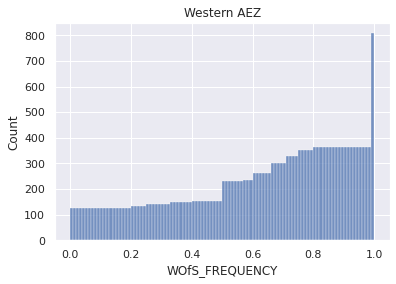

In [33]:
sn.histplot(input_data, x="WOfS_FREQUENCY", cumulative=True,binwidth=0.01).set_title('Western AEZ');
plt.show()

In [309]:
# sn.distplot(CLF['Actual_count']);

In [482]:
confusion_matrix = pd.crosstab(Permanent['CEO_TYPE'],Permanent['WOfS_TYPE'],rownames=['CEO'],colnames=['WOfS'],margins=True)

In [439]:
confusion_matrix["User's"] = [confusion_matrix.loc['Permanent']['Permanent'] / confusion_matrix.loc['Permanent']['All'] * 100, confusion_matrix.loc['Ephemeral']['Ephemeral'] / confusion_matrix.loc['Ephemeral']['All'] *100,np.nan]

In [440]:
producers_accuracy = pd.Series([confusion_matrix['Ephemeral']['Ephemeral'] / confusion_matrix['Ephemeral']['All'] * 100,
                                confusion_matrix['Permanent']['Permanent'] / confusion_matrix['Permanent']['All'] * 100]).rename("Producer's")

confusion_matrix = confusion_matrix.append(producers_accuracy)

In [443]:
confusion_matrix.loc["Producer's", "User's"] = (confusion_matrix['Permanent']['Permanent'] + confusion_matrix['Ephemeral']['Ephemeral']) / confusion_matrix['All']['All'] * 100
confusion_matrix

,Ephemeral,Permanent,All,User's,0,1
CEO,,,,,,
Ephemeral,16.0,21.0,37.0,81.196581,NaN,NaN
Permanent,44.0,190.0,234.0,43.243243,NaN,NaN
All,60.0,211.0,271.0,NaN,NaN,NaN
Producer's,NaN,NaN,NaN,76.014760,26.666667,90.047393


In [198]:
print(metrics.classification_report(CLF['CEO_TYPE'], CLF['WOfS_TYPE'], digits=3))

              precision    recall  f1-score   support

         Dry      0.627     0.822     0.712        45
   Ephemeral      0.183     0.722     0.292        18
   Permanent      0.950     0.741     0.832       305

    accuracy                          0.750       368
   macro avg      0.587     0.762     0.612       368
weighted avg      0.873     0.750     0.791       368



In [199]:
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [200]:
#r_value = r2(CLF["CEO_FREQUENCY"], CLF["WOfS_FREQUENCY"])
r_value = r2(CLF["CEO_FREQUENCY"], CLF["WOfS_FREQUENCY"])
r_value_r = round(r_value, 3)

In [201]:
rmse = (np.sqrt(mean_squared_error(CLF['CEO_FREQUENCY'],CLF['WOfS_FREQUENCY'])))

In [202]:
jaccard_score(CLF["CEO_TYPE"], CLF["WOfS_TYPE"], average=None)

array([0.55223881, 0.17105263, 0.71293375])

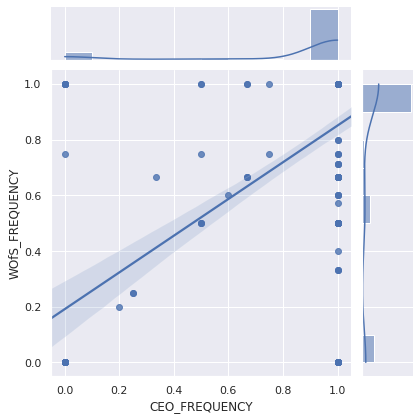

In [203]:
#In order to plot Probability Density functions of each variable, you need to use kind='kde'
ax = sn.jointplot(CLF["CEO_FREQUENCY"], CLF["WOfS_FREQUENCY"], data=CLF, kind='reg', truncate=None);
#ax = sn.jointplot(CLF["CEO_FREQUENCY"], CLF["WOfS_FREQ"], data=CLF, kind='reg', truncate=None);

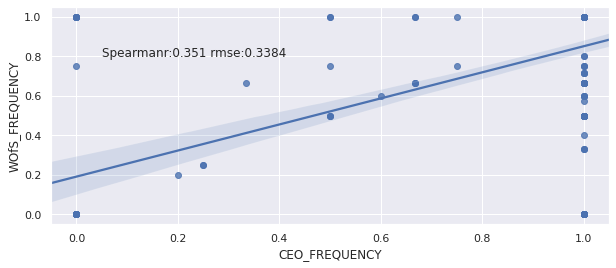

In [204]:
plt.figure(figsize=(10,4))
j = sn.regplot(data=CLF, x='CEO_FREQUENCY', y='WOfS_FREQUENCY',truncate=False);
#j = sn.regplot(data=CLF, x='CEO_FREQUENCY', y='WOfS_FREQ',truncate=False);
j.annotate('Spearmanr:'+str(r_value_r) + ' ' + 'rmse:' + str(round(rmse,4)), xy=(0.05, 0.8));

In [205]:
#Sample_ID = CLF[['WOfS_TYPE','CEO_FREQUENCY','WOfS_FREQUENCY']] 
Sample_ID = CLF[['CLASS','CEO_FREQUENCY','WOfS_FREQUENCY']] 

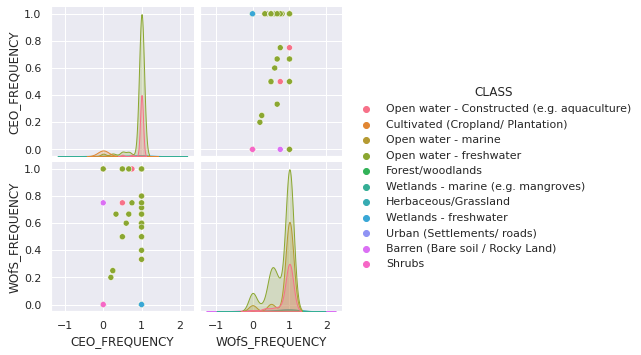

In [206]:
sn.pairplot(Sample_ID, hue='CLASS', size=2.5);

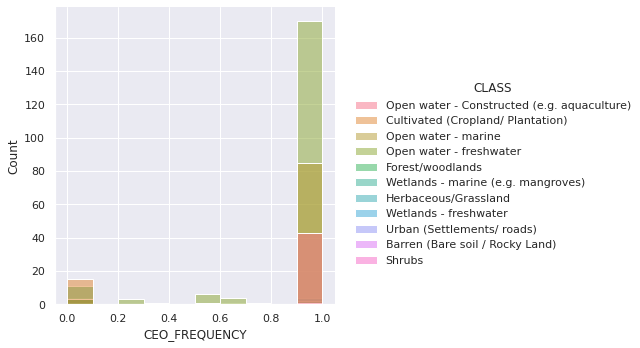

In [207]:
sn.displot(Sample_ID, x="CEO_FREQUENCY", hue="CLASS");

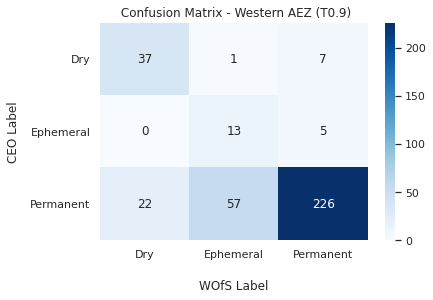

In [208]:
confusion_matrix = pd.crosstab(CLF['CEO_TYPE'],CLF['WOfS_TYPE'],rownames=['CEO'],colnames=['WOfS'])
ax = plt.subplot()
sn.heatmap(confusion_matrix, annot = True, cmap='Blues', fmt='g') #true to annotate cells 
ax.set_xlabel('WOfS Label'); ax.set_ylabel( 'CEO Label');
ax.set_title(' Confusion Matrix - Western AEZ (T0.9)')
ax.xaxis.set_ticklabels(['Dry','Ephemeral','Permanent']); 
ax.yaxis.set_ticklabels(['Dry','Ephemeral','Permanent'], rotation='horizontal');
ax.xaxis.labelpad = 20;
ax.yaxis.labelpad = 10;

In [222]:
confusion_matrix = pd.crosstab(CLF['CLASS'],CLF['WOfS_TYPE'],rownames=['CLASS'],colnames=['WOfS_TYPE'],margins=True)
confusion_matrix

WOfS_TYPE,Dry,Ephemeral,Permanent,All
CLASS,,,,
Barren (Bare soil / Rocky Land),4,0,6,10
Cultivated (Cropland/ Plantation),3,1,2,6
Forest/woodlands,16,3,0,19
Herbaceous/Grassland,5,0,0,5
I am unsure,1,0,0,1
Open water - Constructed (e.g. aquaculture),1,1,6,8
Open water - freshwater,26,45,177,248
Open water - marine,0,0,12,12
Shrubs,4,0,0,4


In [223]:
confusion_matrix2 = pd.crosstab(CLF['CLASS'],CLF['CEO_TYPE'],rownames=['CLASS'],colnames=['CEO_TYPE'],margins=True)
confusion_matrix2

CEO_TYPE,Dry,Ephemeral,Permanent,All
CLASS,,,,
Barren (Bare soil / Rocky Land),5,4,1,10
Cultivated (Cropland/ Plantation),4,0,2,6
Forest/woodlands,18,1,0,19
Herbaceous/Grassland,5,0,0,5
I am unsure,1,0,0,1
Open water - Constructed (e.g. aquaculture),1,1,6,8
Open water - freshwater,11,32,205,248
Open water - marine,0,0,12,12
Shrubs,4,0,0,4


In [ ]:
print(datacube.__version__)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** September 2020

**Compatible datacube version:** 

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)